### **Import**

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# import skimage
import time
import random
import os
from datetime import datetime
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, concatenate
from keras.utils.vis_utils import plot_model
from keras import callbacks

In [48]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
import gc
gc.collect()

16800

In [50]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [51]:
print(np.__version__)
print(tf.__version__)

1.25.0
2.10.0


### **Loading data**

In [52]:
train_data_dir = "C:/Users/lecle/Documents/Kitti_project/archive/training/image_2/"
train_gt_dir = "C:/Users/lecle/Documents/Kitti_project/archive/training/gt_image_2/"

test_data_dir = "C:/Users/lecle/Documents/Kitti_project/archive/testing/"

In [53]:
nb_train_images = len(os.listdir(train_data_dir))
print("Nombre d'images d'entraînement:", nb_train_images)
print("Nombre de filtre:", len(os.listdir(train_gt_dir)))

Nombre d'images d'entraînement: 289
Nombre de filtre: 384


In [54]:
print(len(os.listdir(train_data_dir)))
print(len(os.listdir(train_gt_dir)))

289
384


In [55]:
# loading all mask from the file

def gt_regex_road(path):
    mask_path = tf.strings.regex_replace(path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_") # ne pas prendre um_lane_
    # mask_path = tf.strings.regex_replace(mask_path, "um_", "um_lane_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")
    return mask_path

def gt_regex_lane(path):
    mask_path = tf.strings.regex_replace(path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_lane_")
    return mask_path

In [56]:
# read file from the archive <image and mask>
# resize images ans mask into 128x128
# convert rgb mask into binary mask to get only the road and the background

def process_path(file_path, img_height=128, img_width=128):
    gt_path = gt_regex_road(file_path)

    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])

    mask = tf.io.read_file(gt_path)
    mask = tf.io.decode_png(mask, channels=3)

    non_road_label = np.array([255, 0, 0]) # red
    road_label = np.array([255, 0, 255]) # pink
    other_road_label = np.array([0, 0, 0]) # black

    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2) # become shape (128, 128)

    mask = tf.cast(mask, tf.uint8)

    mask = tf.expand_dims(mask, axis=-1) # shape (128, 128) -> (128, 128, 1)

    mask = tf.image.resize(mask, [img_height, img_width])

    return img, mask

def process_path2(file_path, img_height=128, img_width=128):
    gt_path = gt_regex_lane(file_path)

    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])

    mask = tf.io.read_file(gt_path)
    mask = tf.io.decode_png(mask, channels=3)

    non_road_label = np.array([255, 0, 0]) # red
    road_label = np.array([255, 0, 255]) # pink
    other_road_label = np.array([0, 0, 0]) # black

    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2) # become shape (128, 128)

    mask = tf.cast(mask, tf.uint8)

    mask = tf.expand_dims(mask, axis=-1) # shape (128, 128) -> (128, 128, 1)

    mask = tf.image.resize(mask, [img_height, img_width])

    return img, mask


In [57]:
# load all the dataset
def global_dataset(data: tf.data.Dataset):
    return data.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

def global_dataset2(data: tf.data.Dataset):
    return data.map(process_path2, num_parallel_calls=tf.data.AUTOTUNE)

In [58]:
train_dataset = tf.data.Dataset.list_files([train_data_dir + "um_*.png", train_data_dir + "umm_*.png", train_data_dir + "uu_*.png"], seed=1)
train_dataset2 = tf.data.Dataset.list_files([train_data_dir + "um_*.png"], seed=1, shuffle=False)
print(train_dataset)
# for i, element in enumerate(train_dataset):
#     print(element)
all_train_data = global_dataset(train_dataset)
# lane_train_data = global_dataset2(train_dataset2)

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [59]:
print(all_train_data.element_spec)
# print(lane_train_data.element_spec)

# all_train_data = all_train_data.concatenate(lane_train_data)
print(len(all_train_data))

# for i, element in enumerate(all_train_data):
#     print(element[1].shape)

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))
289


In [60]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor, img_size=[128, 128]) -> tuple:
    input_image = tf.image.resize(input_image, img_size)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.image.resize(input_mask, img_size)
    return input_image, input_mask

In [61]:
all_train_data = all_train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [62]:
print(all_train_data.element_spec)
print(len(all_train_data))

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))
289


In [63]:
nb_train_images = tf.data.experimental.cardinality(all_train_data).numpy()
train_size = int(nb_train_images * 0.3)
test_size = int(nb_train_images * 0.35)
val_ds = all_train_data.skip(train_size + test_size)
train_ds = all_train_data.take(train_size).prefetch(tf.data.AUTOTUNE)
test_ds = all_train_data.take(test_size).prefetch(tf.data.AUTOTUNE)

In [64]:
def load_image(images, labels):
    input_image = images
    input_mask = labels
    return input_image, input_mask

def load_image_test(images, labels):
    input_image = images
    input_mask = labels
    return input_image, input_mask

In [65]:
def configure_for_performance(data, batch_size=8, buffer_size=1000, shuffle=True, batch=True, prefetch=True, reapeat=True, augmentation=True):
    data = data.cache()
    if shuffle:
        data = data.shuffle(buffer_size=buffer_size)
    if batch:
        data = data.batch(batch_size)
    if prefetch:
        data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

### **Data Augmentation**

In [66]:
def displaying(disp, title=None, figsize=(7, 7)):
    plt.rcParams['figure.figsize'] = figsize

    for i, img in enumerate(disp):
        plt.subplot(1, len(disp), i+1)
        try:
            img = np.asarray(img)                
        except:
            img = img
        plt.imshow(img)
        try:
            plt.title(title[i])
        except:
            pass
        
    plt.tight_layout()
    plt.show()

def mask_on_image(image, mask):
    image = np.asarray(image)
    print("asarray ok")
    print(image.shape)
    image = Image.fromarray((image * 255).astype(np.uint8))
    # image = Image.fromarray(image)
    print("image ok")
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    mask = Image.fromarray((mask * 255).astype(np.uint8))
    return Image.blend(image, mask, alpha=0.2)
# for image, mask in dataset["train"].take(1):
#     displaying([image[0], mask[0]], title=["Input image", "True mask"])

asarray ok
(128, 128, 3)
image ok


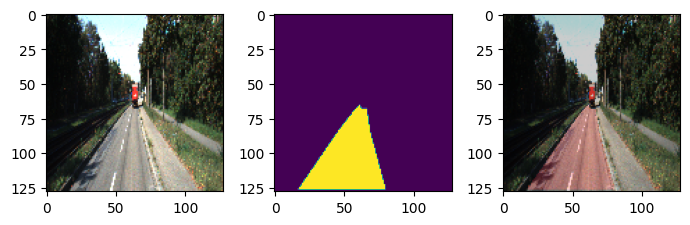

In [67]:
for i, element in enumerate(train_ds):
    element = list(element)
    element.append(mask_on_image(element[0], element[1]))
    displaying(element)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


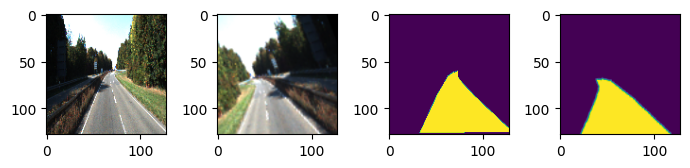

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> (128, 128, 3)


In [68]:
def salt_and_pepper(image, prob_salt=0.05, prob_pepper=0.05):
    random_values = tf.random.uniform(shape=image[0:,  ..., -1:].shape)
    image = tf.where(random_values < prob_salt, 1., image)
    image = tf.where(1 - random_values < prob_pepper, 0., image)
    return image

def new_image(img, mask):
    seed = np.random.uniform(0, 1000000)
    data_augmentation_img = tf.keras.Sequential([
        keras.layers.RandomBrightness(factor=0.2, value_range=(0., 1.)),
        keras.layers.RandomContrast(factor=0.3),
        # keras.layers.RandomFlip(mode="horizontal", seed=seed),
        keras.layers.RandomRotation(factor=0.075, fill_mode='constant', seed=seed),
        keras.layers.RandomCrop(3*img.shape[0]//4, 3*img.shape[1]//4, seed=seed),
        keras.layers.Resizing(
            img.shape[0], img.shape[1], interpolation="bilinear", crop_to_aspect_ratio=False
        ),
    ])
    data_augmentation_mask = tf.keras.Sequential([
        # keras.layers.RandomFlip(mode="horizontal", seed=seed),
        keras.layers.RandomRotation(factor=0.075, fill_mode='constant', seed=seed),
        keras.layers.RandomCrop(3*mask.shape[0]//4, 3*mask.shape[1]//4, seed=seed),
        keras.layers.Resizing(
            mask.shape[0], mask.shape[1], interpolation="bilinear", crop_to_aspect_ratio=False
        ),
    ])
    augmented_img = data_augmentation_img(img)
    augmented_mask = data_augmentation_mask(mask)
    if tf.random.uniform(()) < 0.5:
        augmented_img = tf.image.flip_left_right(augmented_img)
        augmented_mask = tf.image.flip_left_right(augmented_mask)
    if tf.random.uniform(()) < 0.3:
        augmented_img = salt_and_pepper(augmented_img)

    return augmented_img, augmented_mask

for image, mask in all_train_data.take(1):
    augmented_img, augmented_mask = new_image(image, mask)
    # print(augmented_img)
    # for i in  augmented_img:
    #     print(i)
    displaying([image, augmented_img, mask, augmented_mask])
    print(type(image), type(augmented_img), augmented_img.shape)
# displaying([augmented_img, augmented_msk], title=["Input image", "True mask"])

In [69]:
def augment_data(data: tf.data.Dataset, iterator=10):
    augmented = data
    list_augment = []
    for _ in range(iterator):
        da = data.map(lambda img, mask: tf.py_function(new_image, [img, mask], [tf.float32, tf.float32]))
        da = da.map(lambda img, mask: [tf.ensure_shape(img, [128, 128, 3]), tf.ensure_shape(mask, [128, 128, 1])])
        list_augment.append(da)
    return augmented, list_augment

augmented, list_augment = augment_data(data=train_ds, iterator=20)
augmented = augmented.map(lambda img, mask: [tf.ensure_shape(img, [128, 128, 3]), tf.ensure_shape(mask, [128, 128, 1])])

[<MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>, <MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>, <MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>, <MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>, <MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>, <MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>, <MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),

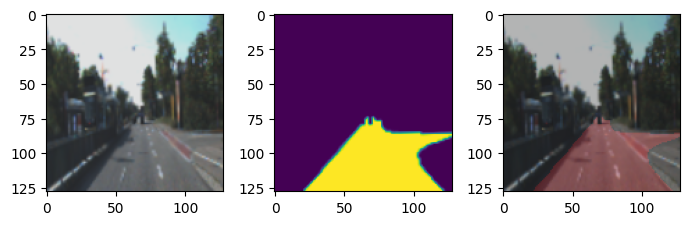

In [70]:
print(list_augment)
for image, mask in list_augment[0].take(1):
    overlap = mask_on_image(image, mask)
    displaying([image, mask, overlap])

In [71]:
for tensor in list_augment:
    augmented = augmented.concatenate(tensor)

In [72]:
print(tf.data.experimental.cardinality(all_train_data).numpy())
print(tf.data.experimental.cardinality(augmented).numpy())

289
1806


In [73]:
print(all_train_data.element_spec)
print(augmented.element_spec)

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))


In [74]:
augmented = augmented.shuffle(buffer_size=1000, reshuffle_each_iteration=True)

### **Model**

In [75]:
batch_size = 16

dataset = {"train": augmented, "val": val_ds, "test": test_ds}

# -- Train Dataset --#
augment = dataset["train"]
# dataset['train'] = augment.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset['train'] = configure_for_performance(dataset["train"], batch_size=batch_size, augmentation=False)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image)
dataset['val'] = configure_for_performance(dataset["val"], batch_size=batch_size, augmentation=False)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image)
dataset['test'] = configure_for_performance(dataset["test"], batch_size=batch_size, shuffle=False, augmentation=False)

print(len(dataset['train']), dataset['train'].element_spec)
print(len(dataset['val']), dataset['val'].element_spec)
print(len(dataset['test']), dataset['test'].element_spec)

113 (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
7 (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
7 (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))


In [76]:
input_shape = (128, 128, 3)

In [77]:
inputs = Input(input_shape)

# VGG network
vgg16_model = keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

# Encoder Layers
c0 = vgg16_model.get_layer("block1_pool").output         
c1 = vgg16_model.get_layer("block2_pool").output   
c2 = vgg16_model.get_layer("block3_pool").output         
c3 = vgg16_model.get_layer("block4_pool").output         
c4 = vgg16_model.get_layer("block5_pool").output   

output_layer = [c4, c3, c2, c1, c0]
filters=512
x = output_layer[0]
for _ in range(len(output_layer)):
    # Upsampling using the pooling indices
    x = keras.layers.UpSampling2D((2, 2), interpolation='bilinear')(x)
    
    x = keras.layers.Conv2DTranspose(filters, (2, 2), activation='relu', padding='same')(x)
    
    x = keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    
    filters //= 2  # Reduce the number of filters
output = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

model = keras.Model(inputs, output, name = "VGG_FCN8")
model.summary()

Model: "VGG_FCN8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [78]:
model.output

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'conv2d_32')>

In [79]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [80]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'vgg16_mdl1.hdf5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
)
earlystop = keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='min'
)
csvlogger = keras.callbacks.CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [checkpoint, earlystop, csvlogger, tensorboard_callback]

m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[m_iou, "accuracy"]
)

In [81]:
EPOCHS = 50
STEPS_PER_EPOCH = train_size // batch_size
print(STEPS_PER_EPOCH)
VALIDATION_STEPS = test_size // batch_size
print(VALIDATION_STEPS)

5
6


In [82]:
model_history = model.fit(dataset['train'], 
                          epochs=EPOCHS,
                          validation_data = dataset["val"],
                          callbacks=callbacks
                          )

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 203986993152.0000 - mean_io_u_1: 0.4169 - accuracy: 0.7353
Epoch 1: loss improved from inf to 203986993152.00000, saving model to vgg16_mdl1.hdf5
113/113 [==============================] - 1085s 174ms/step - loss: 203986993152.0000 - mean_io_u_1: 0.4169 - accuracy: 0.7353 - val_loss: 0.4866 - val_mean_io_u_1: 0.4148 - val_accuracy: 0.8237
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 4.7033 - mean_io_u_1: 0.4139 - accuracy: 0.7808
Epoch 2: loss improved from 203986993152.00000 to 4.70333, saving model to vgg16_mdl1.hdf5
113/113 [==============================] - 14s 120ms/step - loss: 4.7033 - mean_io_u_1: 0.4139 - accuracy: 0.7808 - val_loss: 0.4563 - val_mean_io_u_1: 0.4148 - val_accuracy: 0.8260
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 0.4813 - mean_io_u_1: 0.4144 - accuracy: 0.7908
Epoch 3: loss improved from 4.70333 to 0.48127, saving model to vgg16_mdl1.hdf5


In [83]:
model.evaluate(dataset["test"])

7/7 [==============================] - 1s 30ms/step - loss: 0.4583 - mean_io_u_1: 0.4147 - accuracy: 0.8257


[0.45825445652008057, 0.41470879316329956, 0.8257313370704651]

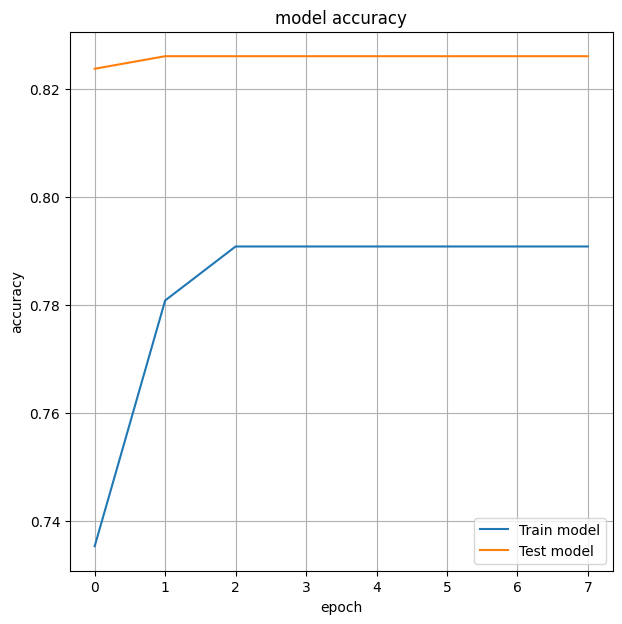

In [84]:
ax = plt.axes()

ax.plot(model_history.history["accuracy"], label="Train model")
ax.plot(model_history.history["val_accuracy"], label="Test model")
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(loc='lower right')
ax.grid()
plt.show()

In [85]:
plot_model(model=model, to_file="model_plt.png", show_shapes=True, rankdir="TB")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
%tensorboard --logdir logs/fit

In [86]:
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    
    # Convert to image image
    image = np.asarray(image, np.float32)
    
    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1
        break

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{index}.png")
    plt.show()

Processing image : 0
1/1 [==============================] - 0s 188ms/step


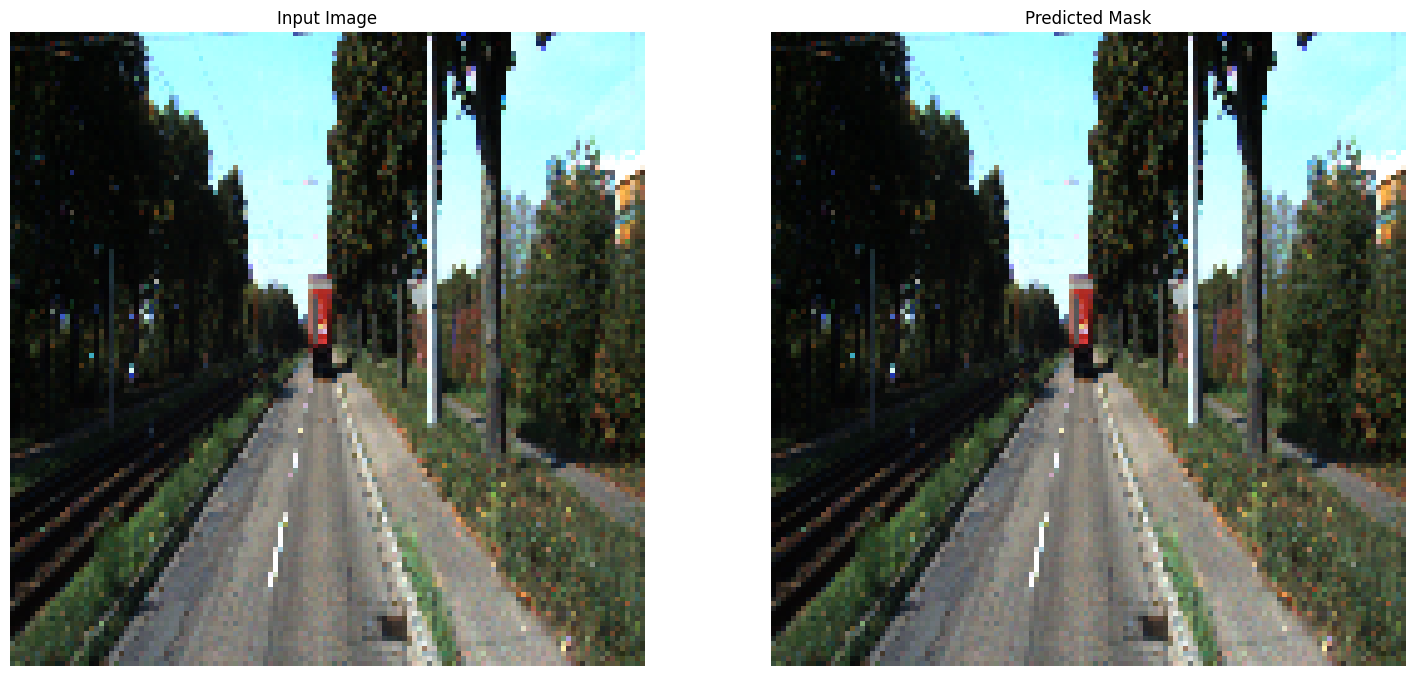

Processing image : 1
1/1 [==============================] - 0s 19ms/step


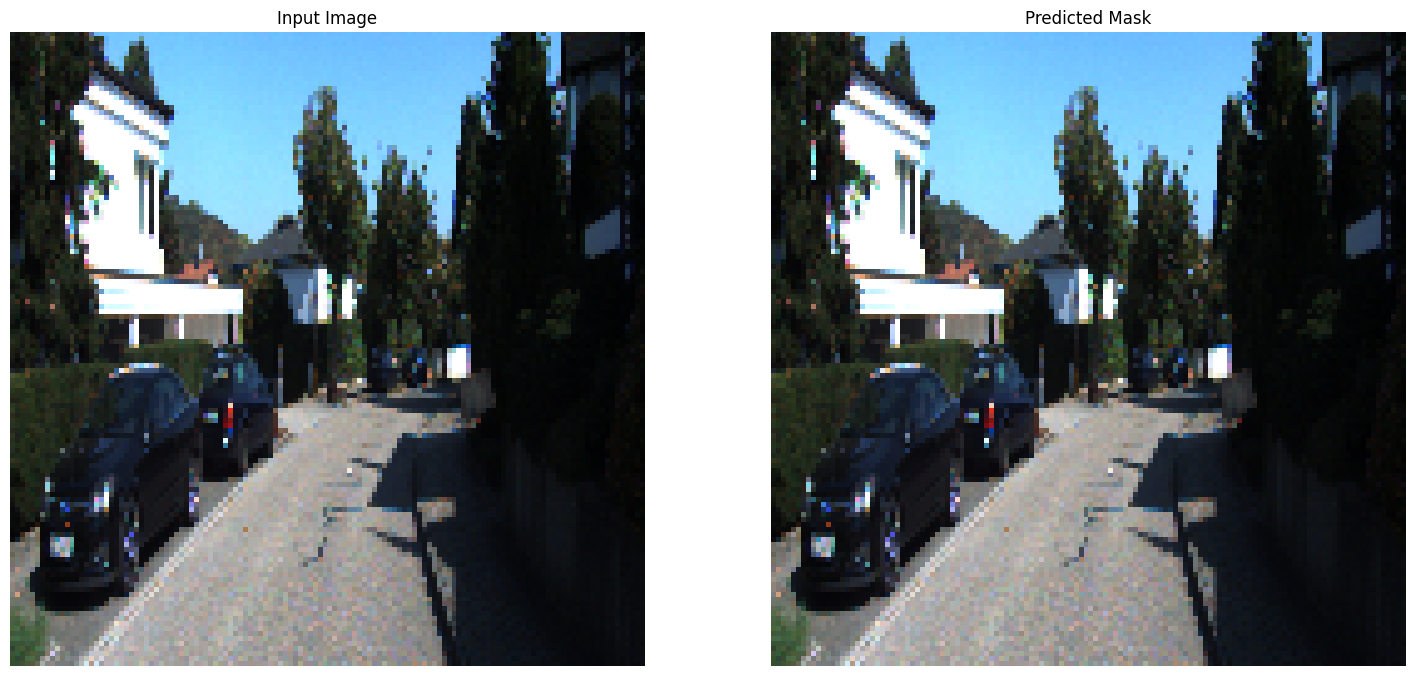

Processing image : 2
1/1 [==============================] - 0s 20ms/step


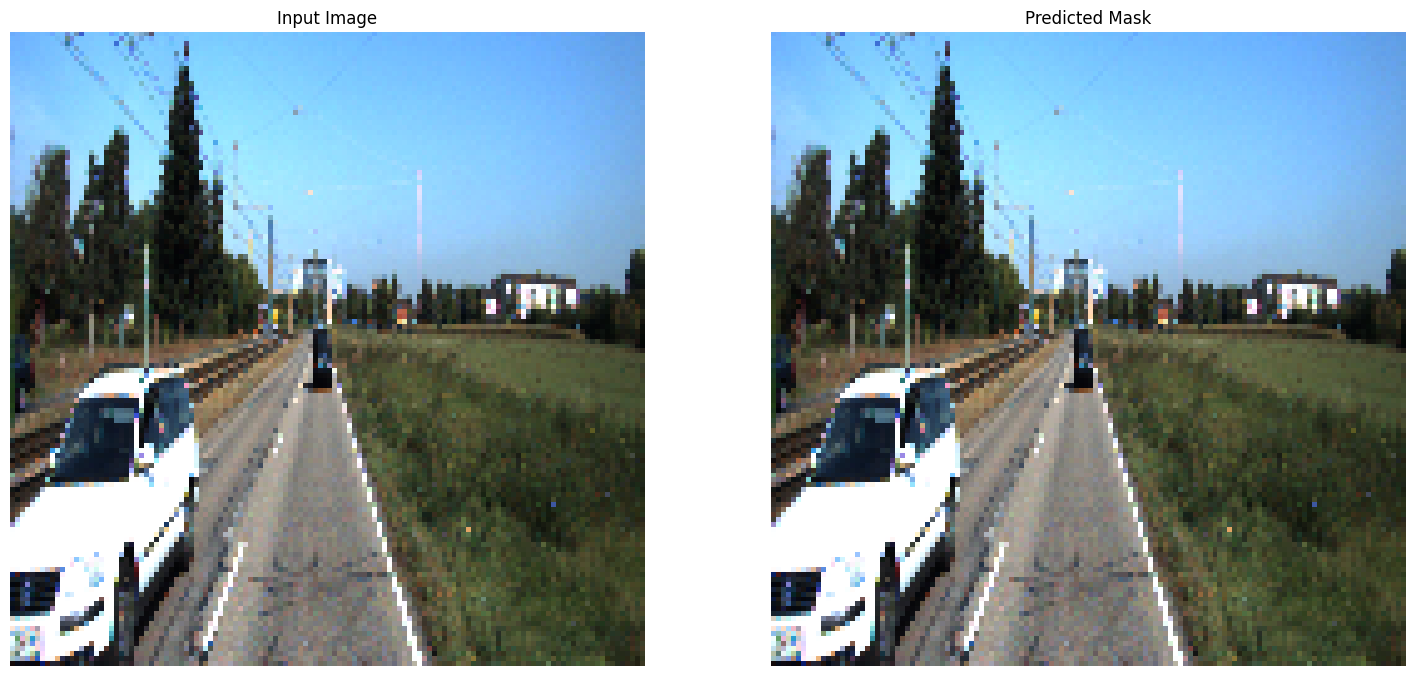

Processing image : 3
1/1 [==============================] - 0s 19ms/step


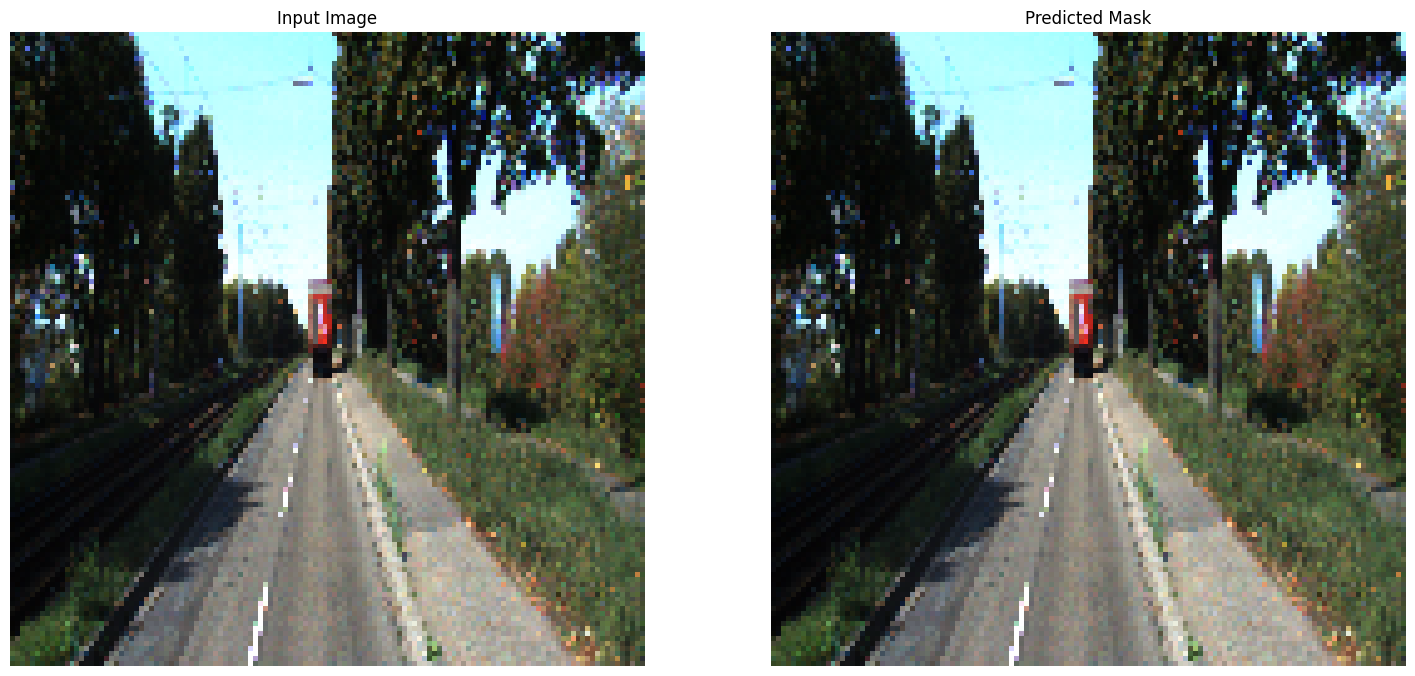

Processing image : 4
1/1 [==============================] - 0s 20ms/step


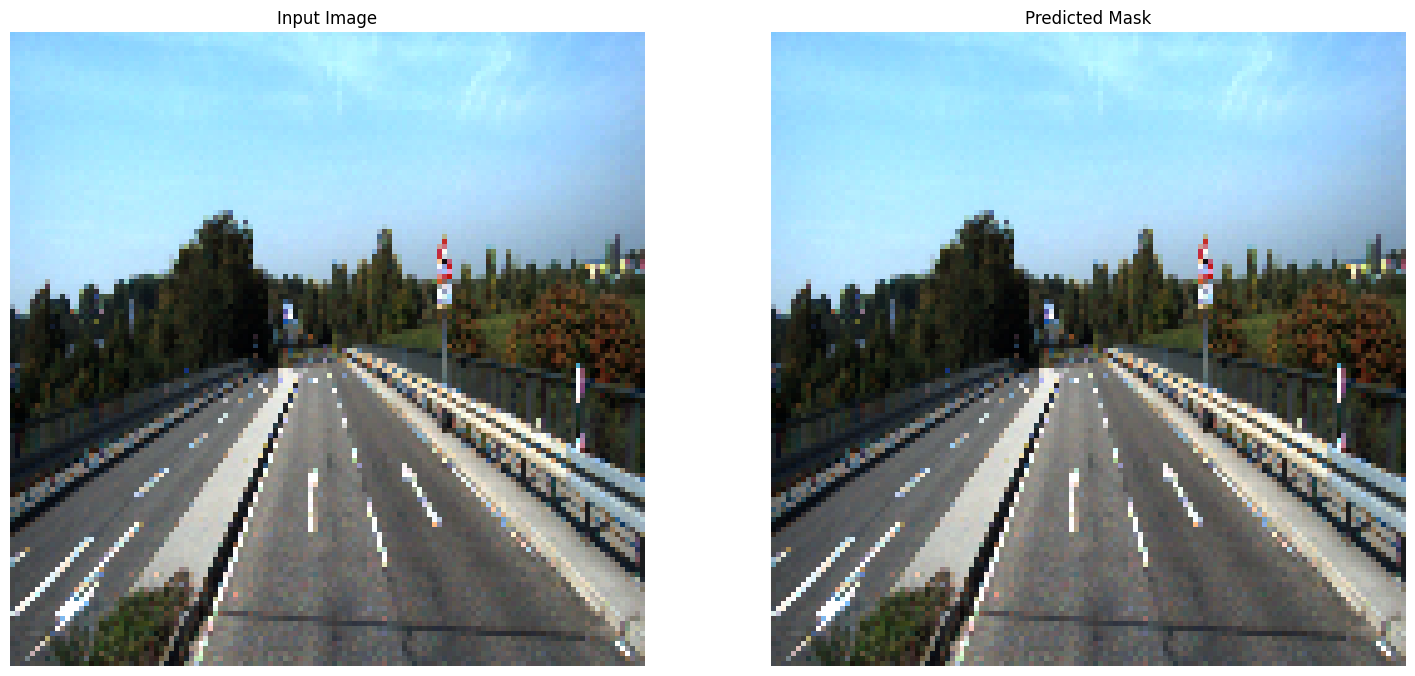

Processing image : 5
1/1 [==============================] - 0s 18ms/step


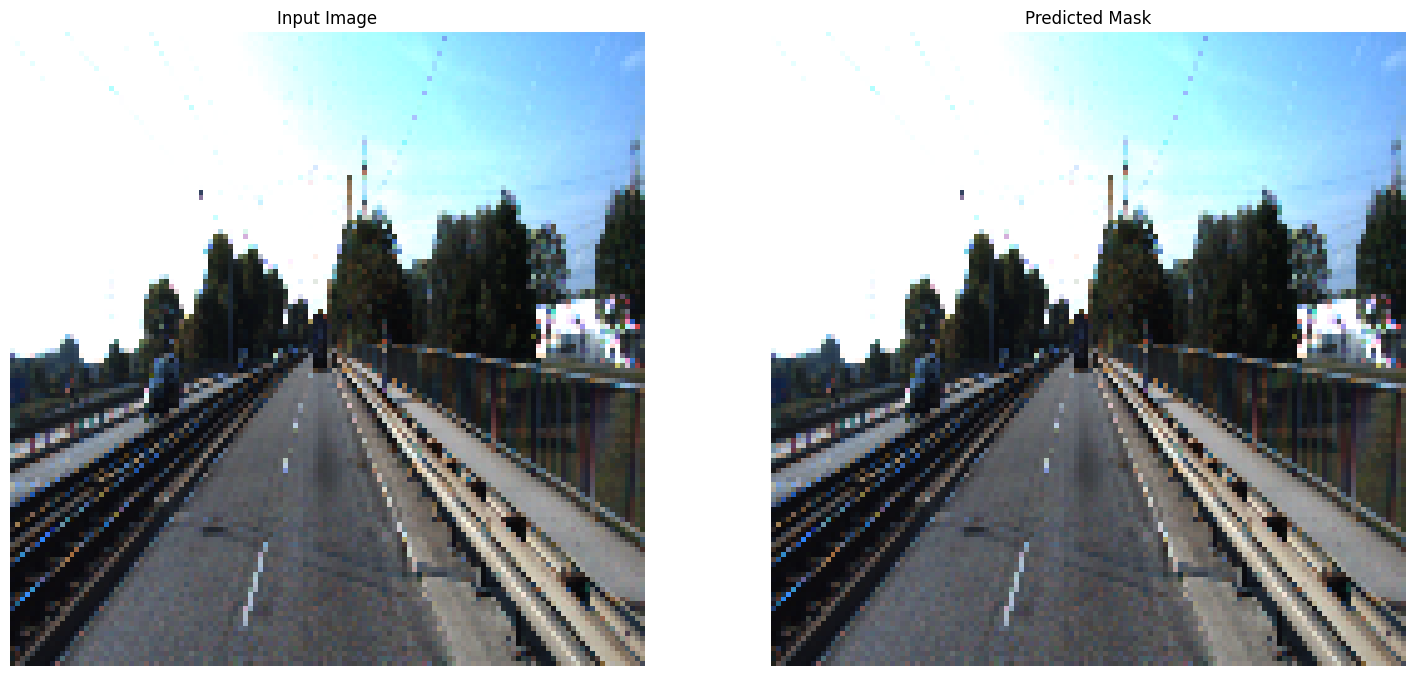

Processing image : 6
1/1 [==============================] - 0s 17ms/step


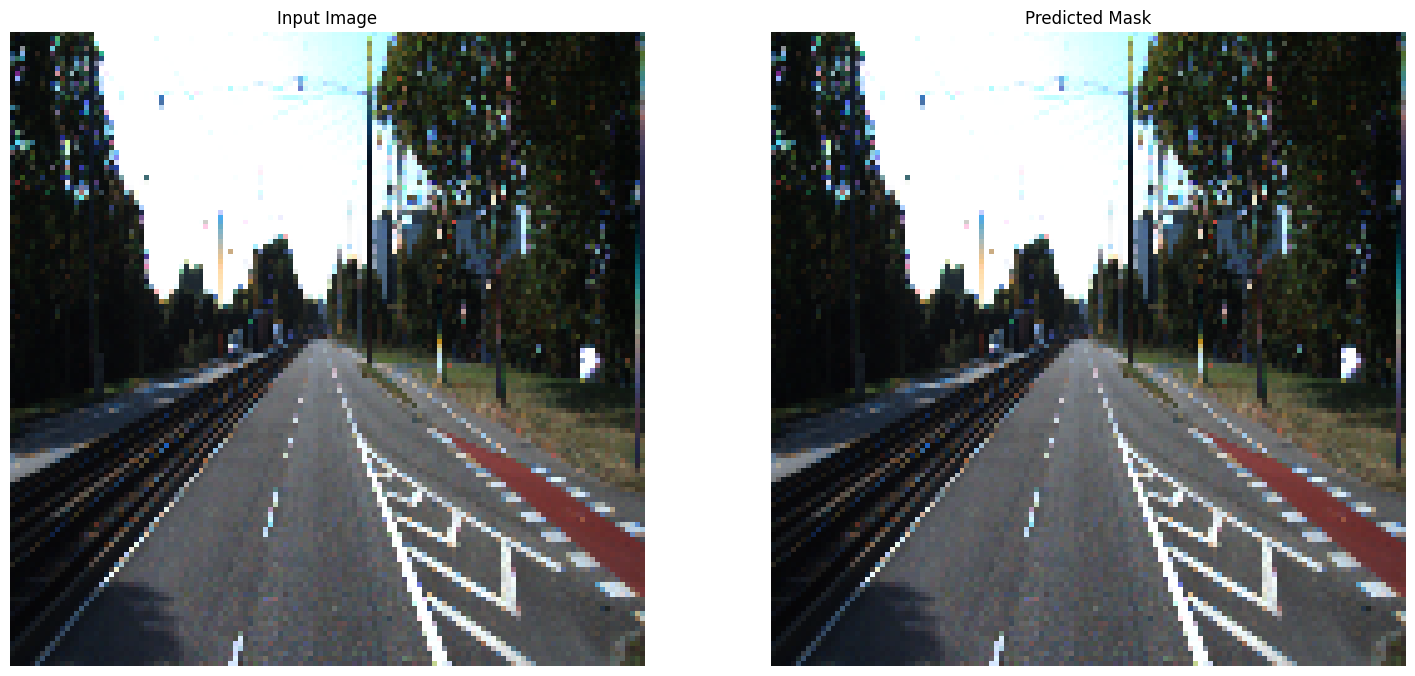

Processing image : 7
1/1 [==============================] - 0s 21ms/step


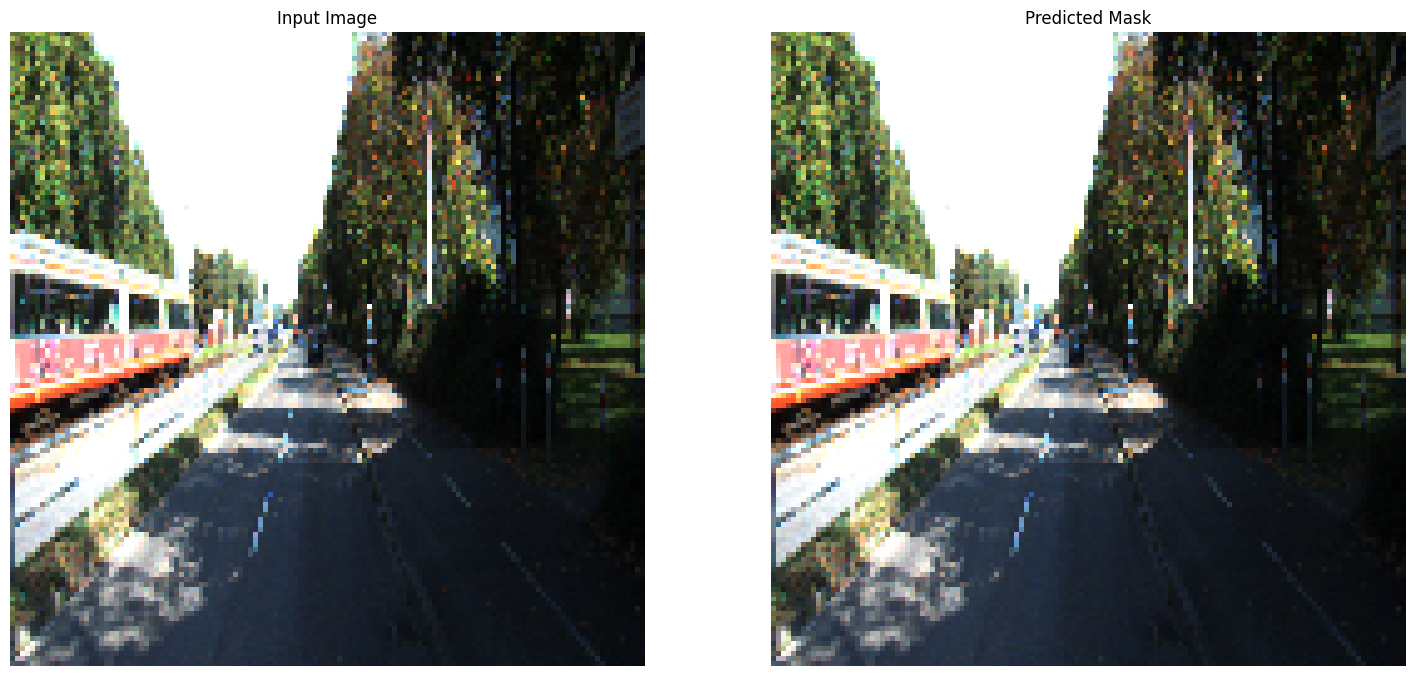

Processing image : 8
1/1 [==============================] - 0s 18ms/step


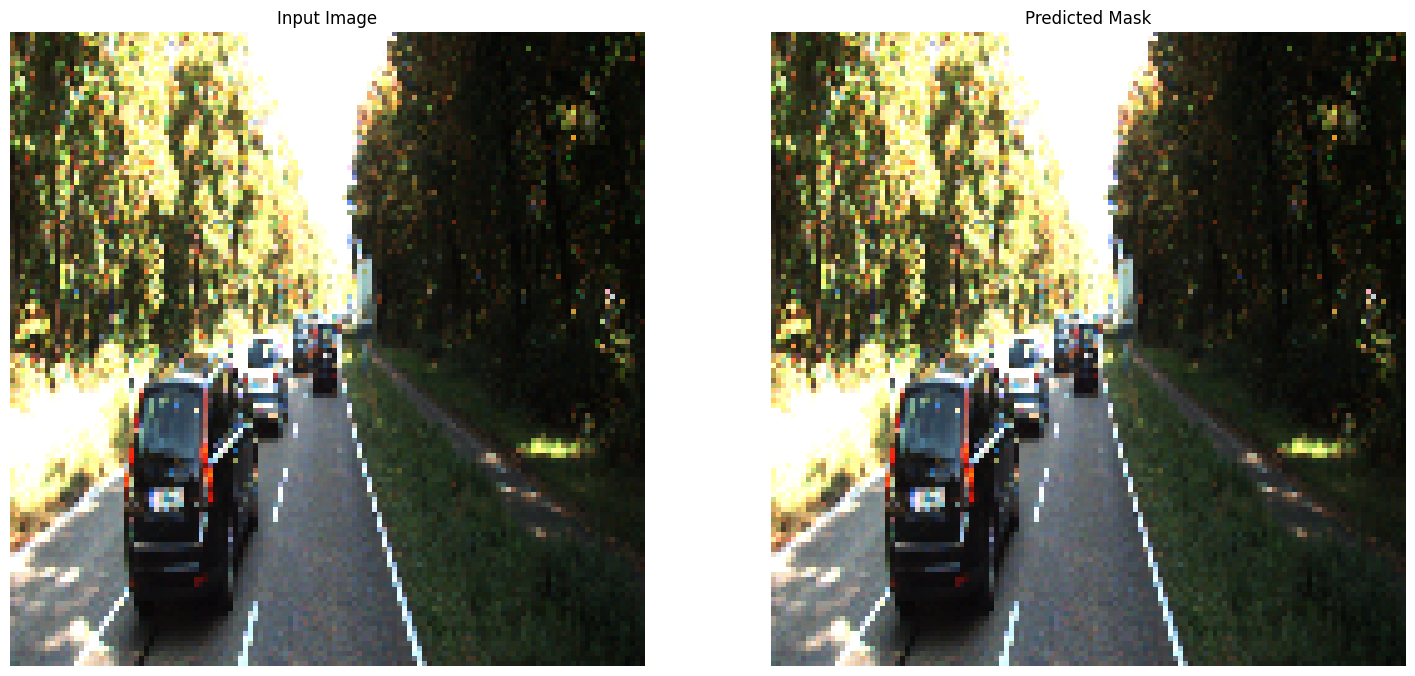

Processing image : 9
1/1 [==============================] - 0s 19ms/step


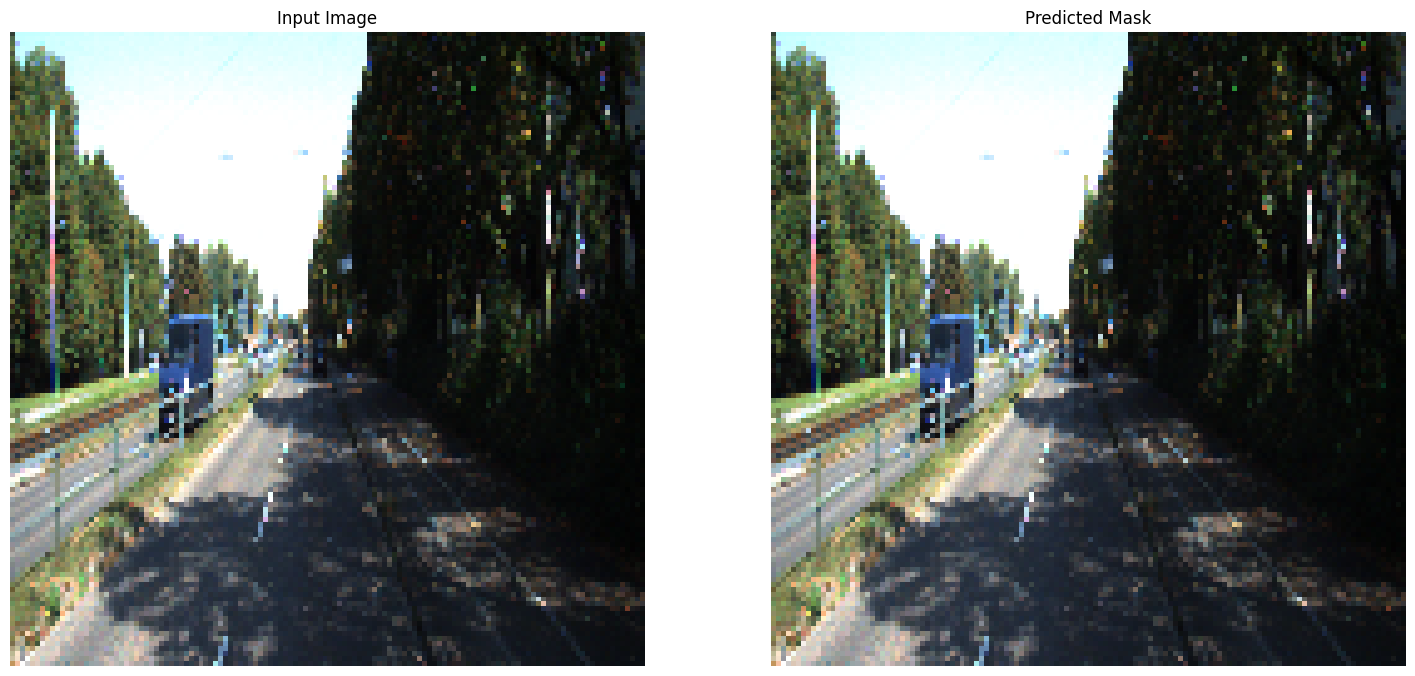

Processing image : 10
1/1 [==============================] - 0s 24ms/step


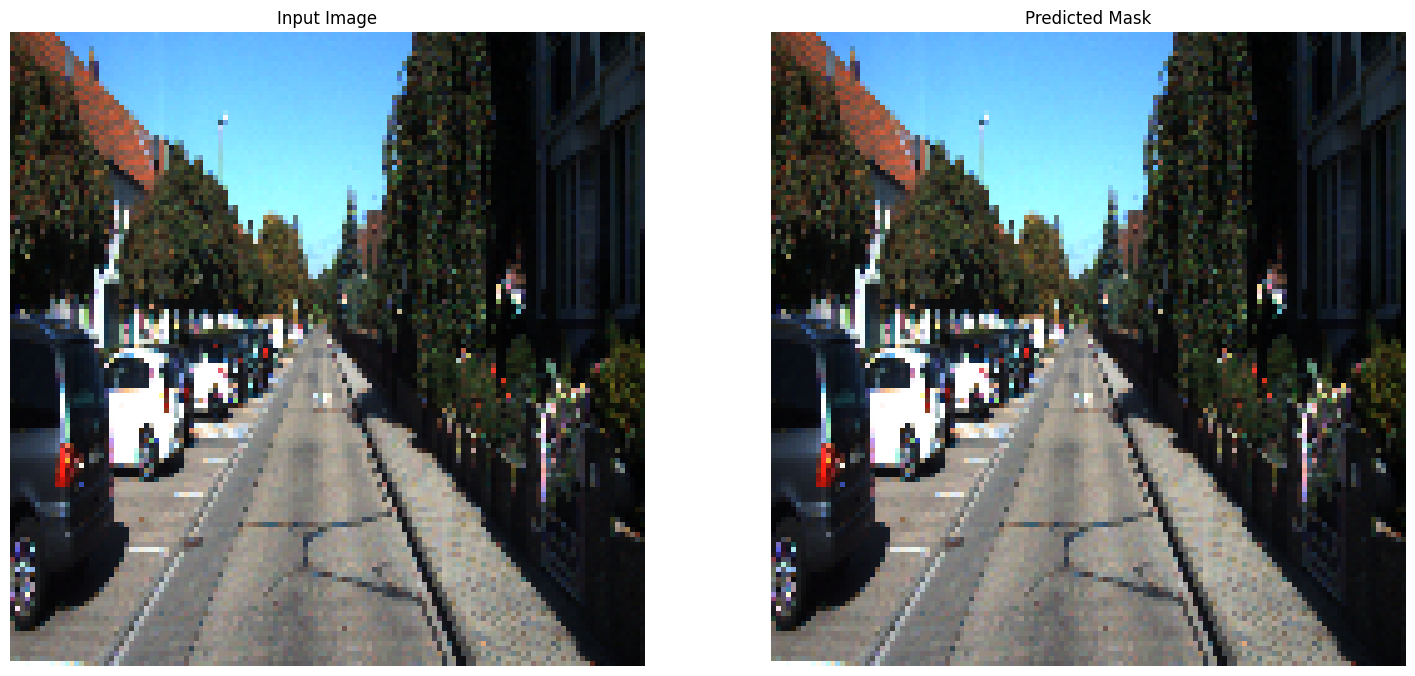

Processing image : 11
1/1 [==============================] - 0s 26ms/step


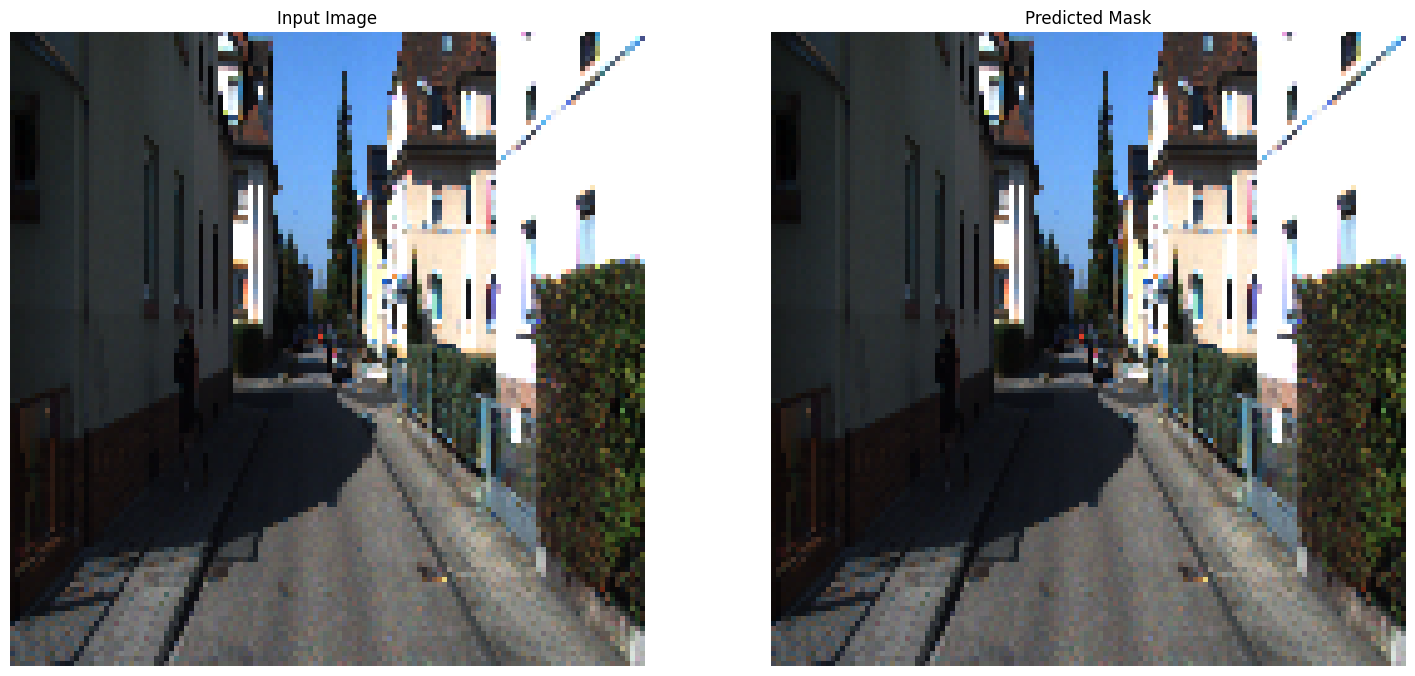

Processing image : 12
1/1 [==============================] - 0s 19ms/step


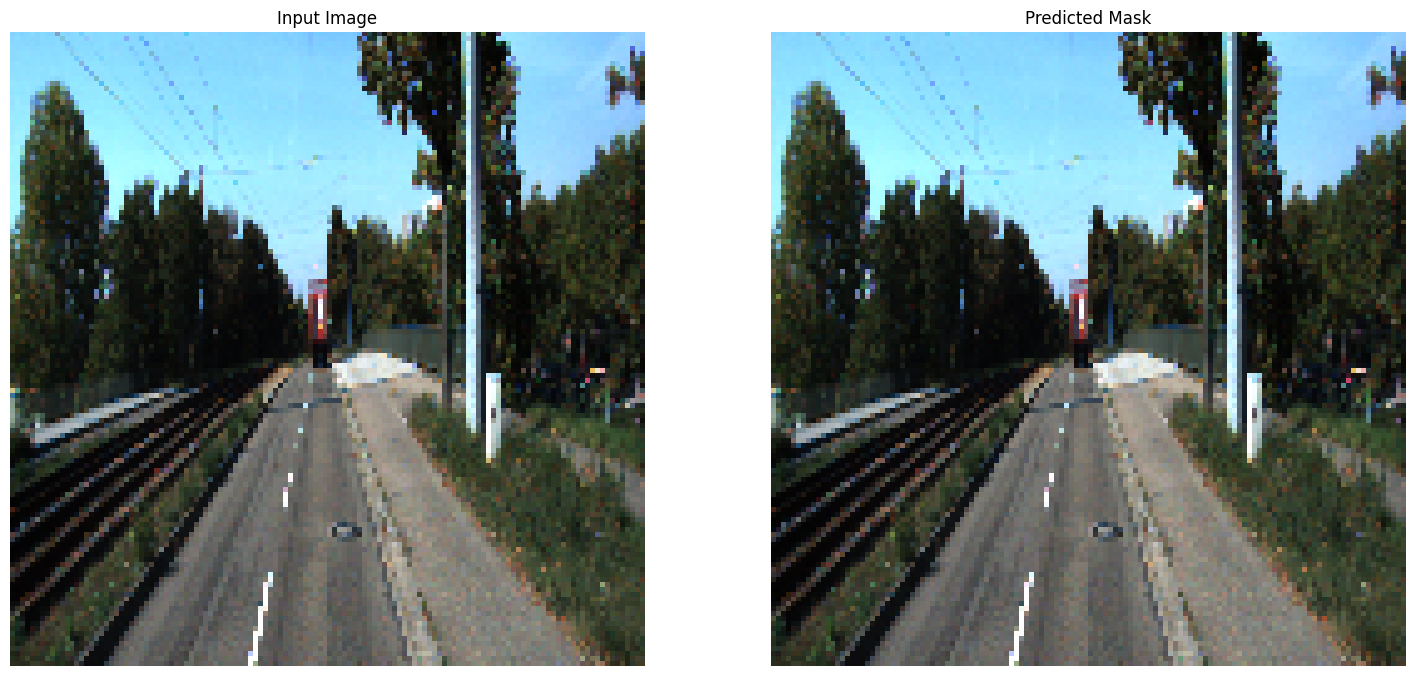

Processing image : 13
1/1 [==============================] - 0s 20ms/step


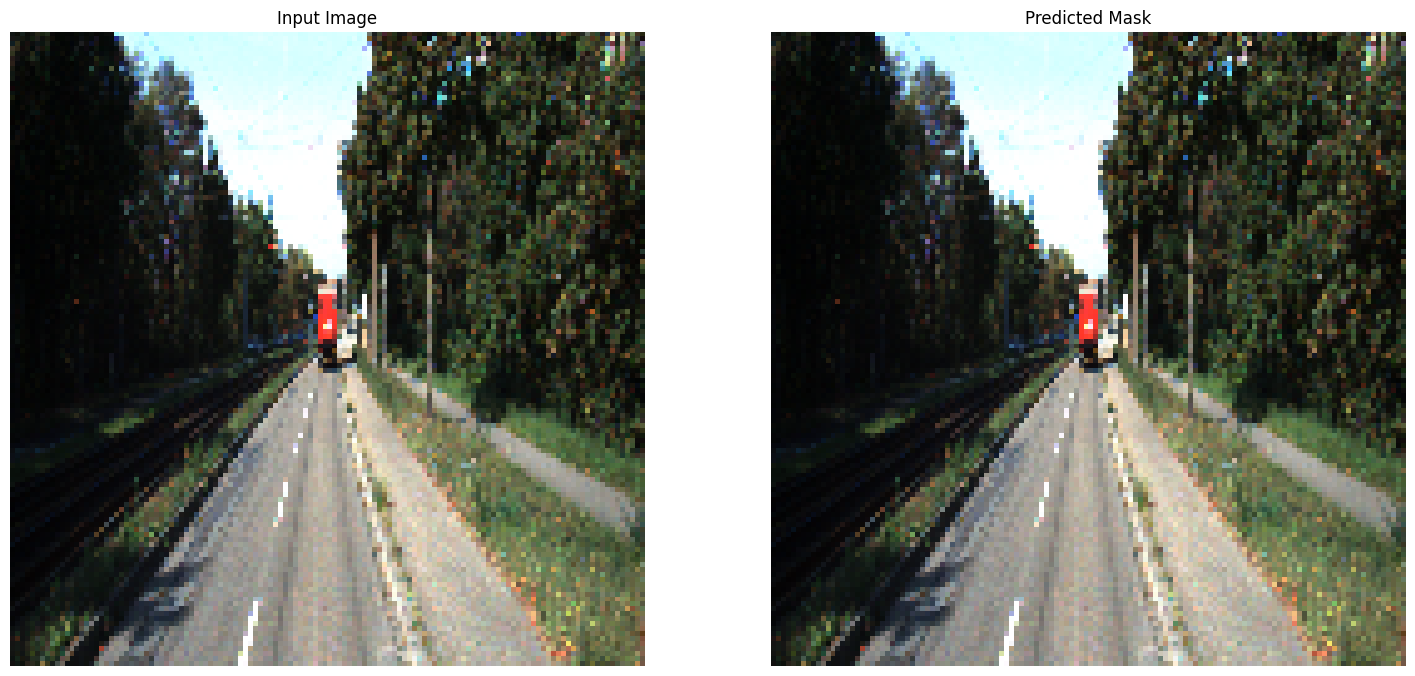

Processing image : 14
1/1 [==============================] - 0s 18ms/step


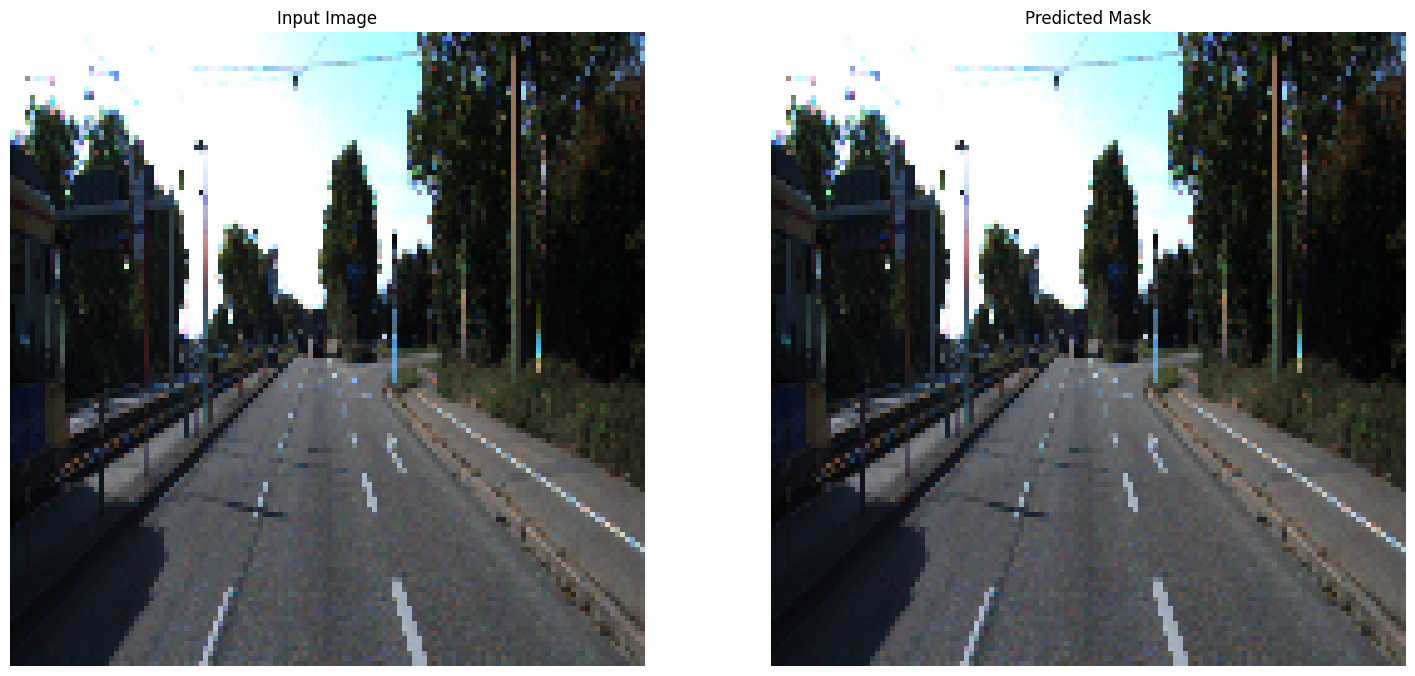

Processing image : 15
1/1 [==============================] - 0s 21ms/step


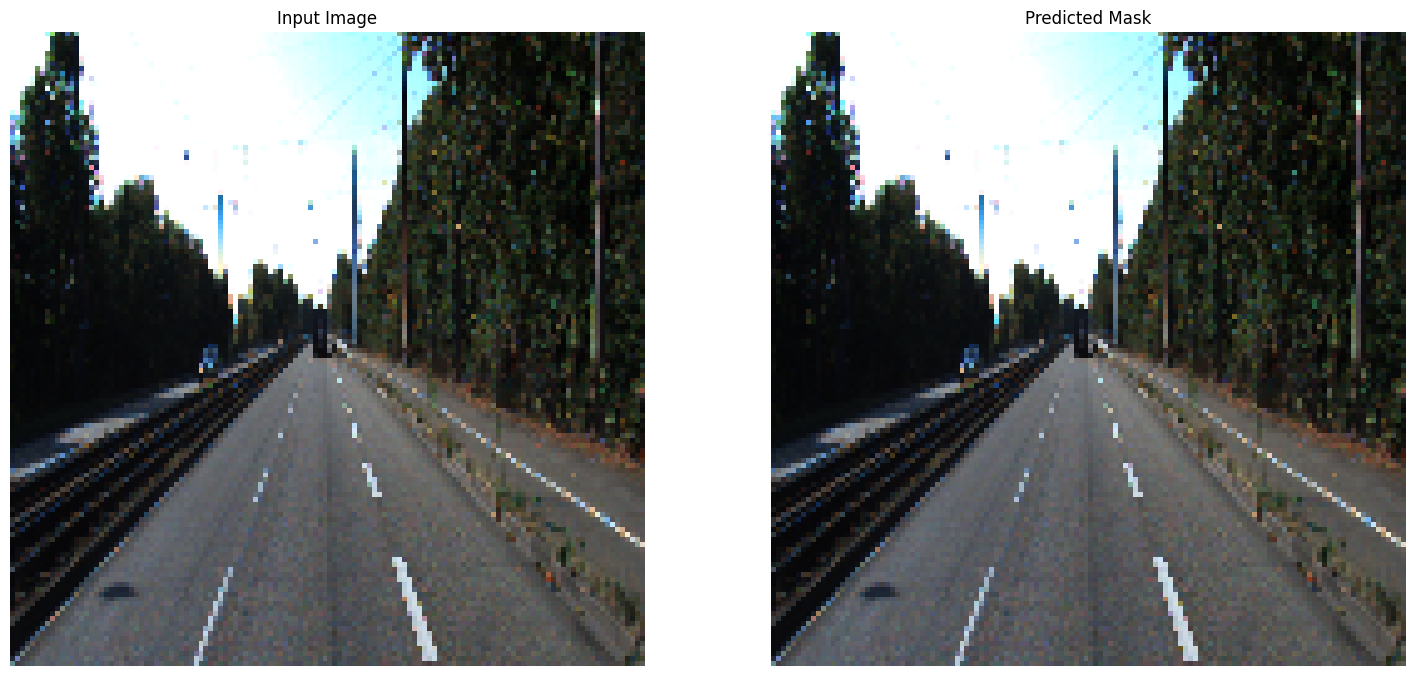

In [87]:
# os.mkdir("outputs")
save_predictions(dataset['test'])